# Optimizing Remove duplicates

In [2]:
# Problem statement to generate 2 lists, one of cascades and another of timestamps.
import random

def generate_number_list(n, start, end):
    """
    Generates a list of n random numbers within a specified range (inclusive).

    Args:
      n: The number of elements in the list.
      start: The starting value of the range (inclusive).
      end: The ending value of the range (inclusive).

    Returns:
      A list of n random numbers within the specified range.
    """
    numbers = []
    for _ in range(n):
        numbers.append(random.randint(start, end))
    return numbers

from datetime import datetime, timedelta

def generate_timestamp_list(n, start_time, end_time):
    """
    Generates a list of n random timestamps within a specified time range.

    Args:
      n: The number of timestamps in the list.
      start_time: The starting datetime object (inclusive).
      end_time: The ending datetime object (inclusive).

    Returns:
      A list of n random timestamps within the specified time range.
    """
    time_delta = end_time - start_time
    total_seconds = time_delta.total_seconds()
    timestamps = []
    for _ in range(n):
    # Generate random number of seconds within the time range
        random_seconds = random.randint(0, int(total_seconds))
        # Add random seconds to start time to get a random timestamp
        timestamp = start_time + timedelta(seconds=random_seconds)
        timestamps.append(timestamp)
    return timestamps



In [4]:
%%time
# Example usage (assuming start_time and end_time are defined as datetime objects)
N = 100000
today = datetime.today()
one_year_ago = today - timedelta(days=365)

timestamps = generate_timestamp_list(N, start_time=one_year_ago, end_time=today)
nodes = generate_number_list(N, 3, 7)

print(len(timestamps), len(nodes))

100000 100000
CPU times: user 123 ms, sys: 4.06 ms, total: 127 ms
Wall time: 127 ms


In [35]:
def remove_duplicates(cascade_nodes, cascade_times):
    """
    Summary:
    Some tweets have more then one retweets from the same person
    Keep only the first retweet of that person

    Return:
    Updated list of cascade nodes and corresponding cascade times
    
    This implementation is from the fair_at_scale repo.
    """
    duplicates = set([x for x in cascade_nodes if cascade_nodes.count(x) > 1])
    for d in duplicates:
        to_remove = [v for v, b in enumerate(cascade_nodes) if b == d][1:]
        to_remove = set(to_remove)
        cascade_nodes = [b for v, b in enumerate(cascade_nodes) if v not in to_remove]
        cascade_times = [b for v, b in enumerate(cascade_times) if v not in to_remove]

    return cascade_nodes, cascade_times

def remove_duplicates_fast(cascade_nodes, cascade_times):
    """
    Summary:
    Removes duplicate cascade nodes while preserving corresponding times.

    Args:
      cascade_nodes: List of cascade nodes (e.g., user IDs).
      cascade_times: List of corresponding timestamps for each cascade node.

    Returns:
      A tuple containing the filtered lists: (unique_cascade_nodes, unique_cascade_times).
      
    This implementation removes duplicates in one pass through cascade nodes and times.
    """
    seen = set()
    unique_cascade_nodes = []
    unique_cascade_times = []
    for node, time in zip(cascade_nodes, cascade_times):
        if node not in seen:
            seen.add(node)
            unique_cascade_nodes.append(node)
            unique_cascade_times.append(time)
    return unique_cascade_nodes, unique_cascade_times

from concurrent.futures import ProcessPoolExecutor
import multiprocessing

def divide_conquer_remove_duplicates(cascade_nodes, cascade_times, is_worker=True):
    """
    Summary:
    Removes duplicate cascade nodes while preserving corresponding times using a divide and conquer approach.

    Args:
    cascade_nodes: List of cascade nodes (e.g., user IDs).
    cascade_times: List of corresponding timestamps for each cascade node.

    Returns:
    A tuple containing the filtered lists: (unique_cascade_nodes, unique_cascade_times).
    
    This implementation uses a divide and conquer approach across all available CPUs.
    """

    # Base case for small lists
    if len(cascade_nodes) <= 100:
        seen = set()
        unique_cascade_nodes = []
        unique_cascade_times = []
        for node, time in zip(cascade_nodes, cascade_times):
            if node not in seen:
                seen.add(node)
                unique_cascade_nodes.append(node)
                unique_cascade_times.append(time)
        return unique_cascade_nodes, unique_cascade_times

    # Divide the lists into halves
    mid = len(cascade_nodes) // 2
    left_nodes, left_times = cascade_nodes[:mid], cascade_times[:mid]
    right_nodes, right_times = cascade_nodes[mid:], cascade_times[mid:]

    # Use concurrent processes to remove duplicates in halves
    if is_worker:
        unique_left_nodes, unique_left_times = divide_conquer_remove_duplicates(left_nodes, left_times)
        unique_right_nodes, unique_right_times = divide_conquer_remove_duplicates(right_nodes, right_times)
    else:
        with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
            unique_left_nodes, unique_left_times = executor.submit(
                divide_conquer_remove_duplicates, left_nodes, left_times
            ).result()
            unique_right_nodes, unique_right_times = executor.submit(
                divide_conquer_remove_duplicates, right_nodes, right_times
            ).result()

    # Merge the results and remove duplicates between halves
    seen = set(unique_left_nodes)
    unique_cascade_nodes = unique_left_nodes.copy()
    unique_cascade_times = unique_left_times.copy()
    for node, time in zip(unique_right_nodes, unique_right_times):
        if node not in seen:
            seen.add(node)
            unique_cascade_nodes.append(node)
            unique_cascade_times.append(time)

    return unique_cascade_nodes, unique_cascade_times

### `remove_duplicates`: Original vs one-pass fast vs divide-and-conquer

In [6]:
%%time
normal_cascades, normal_times = remove_duplicates(cascade_nodes=nodes, cascade_times=timestamps)


# Example output:
# CPU times: user 1min 1s, sys: 349 ms, total: 1min 1s
# Wall time: 1min 2s


CPU times: user 1min, sys: 299 ms, total: 1min 1s
Wall time: 1min 1s


In [9]:
%%time
fast_cascades, fast_times = remove_duplicates_fast(cascade_nodes=nodes, cascade_times=timestamps)
assert normal_cascades == fast_cascades # assert for correctness
assert normal_times == fast_times  # assert for correctness

# Example output:
# CPU times: user 6.91 ms, sys: 751 µs, total: 7.66 ms
# Wall time: 10.6 ms


CPU times: user 6.75 ms, sys: 2.02 ms, total: 8.77 ms
Wall time: 13.8 ms


In [10]:
%%time
dc_cascades, dc_times = divide_conquer_remove_duplicates(cascade_nodes=nodes, cascade_times=timestamps)
assert normal_cascades == dc_cascades  # assert for correctness
assert normal_times == dc_times  # assert for correctness

# Example output:
# CPU times: user 16.1 ms, sys: 2.74 ms, total: 18.9 ms
# Wall time: 27.9 ms

CPU times: user 16.1 ms, sys: 2.74 ms, total: 18.9 ms
Wall time: 27.9 ms


### Comparing between fast and divide and conquer approaches

In [11]:
%%time
# Example usage (assuming start_time and end_time are defined as datetime objects)
N_big = 10000000
today = datetime.today()
one_year_ago = today - timedelta(days=365)

nodes_big = generate_number_list(N_big, 3, 7)
timestamps_big = generate_timestamp_list(N_big, start_time=one_year_ago, end_time=today)

print(len(timestamps_big), len(nodes_big))

10000000 10000000
CPU times: user 10.6 s, sys: 193 ms, total: 10.8 s
Wall time: 10.9 s


In [12]:
%%time
fast_cascades, fast_times = remove_duplicates_fast(cascade_nodes=nodes_big, cascade_times=timestamps_big)


CPU times: user 262 ms, sys: 35.6 ms, total: 298 ms
Wall time: 300 ms


In [13]:
%%time
divide_conquer_remove_duplicates(cascade_nodes=nodes_big, cascade_times=timestamps_big)

CPU times: user 1.27 s, sys: 183 ms, total: 1.45 s
Wall time: 1.46 s


([3, 4, 7, 5, 6],
 [datetime.datetime(2023, 8, 1, 3, 36, 14, 850631),
  datetime.datetime(2023, 10, 12, 10, 20, 14, 850631),
  datetime.datetime(2023, 8, 16, 6, 36, 57, 850631),
  datetime.datetime(2023, 4, 4, 14, 13, 4, 850631),
  datetime.datetime(2023, 5, 27, 0, 44, 27, 850631)])

# Optimizing mapped_uid

In [15]:
DATA_INIT_PATH = "data/"

In [16]:
def mapped_uid():
    """
    Summary:
    Establishes a mapping between user ID and their index in the file

    Return:
    Dictionary with user ID as key and index as value
    
    This implementation is from the fair_at_scale repo.
    """
    file_path = DATA_INIT_PATH + "uidlist.txt"
    with open(file_path, "r", encoding="gbk") as f:
        lines_uid = f.readlines()

    uid_map = {}
    for idx, uid in enumerate(lines_uid):
        uid_map[uid.strip()] = idx

    return uid_map

def mapped_uid_fast():
    """
    Summary:
    Establishes a mapping between user ID and their index in the file

    Return:
    Dictionary with user ID as key and index as value
    
    This is optimized by creating a dictionary in place and iterating through the file lines instead of reading it first.
    """
    file_path = DATA_INIT_PATH + "uidlist.txt"
    with open(file_path, "r", encoding="gbk") as f:
        uid_map = {uid.strip(): idx for idx, uid in enumerate(f)}

    return uid_map


In [65]:
import time
import matplotlib.pyplot as plt
import numpy as np

def run_func_N_times(func, func_name, N=10):
    # List to store execution times
    times = []
    num_runs = 10  # Number of times to run the function

    for _ in range(num_runs):
        start_time = time.time()
        normal_contents = func()
        end_time = time.time()
        times.append(end_time - start_time)

    # Calculate average time
    average_time = sum(times) / len(times)

    plot_times(y_arr=times,func_name=func_name)
    
def plot_times(y_arr, func_name):
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(y_arr, bins=100, edgecolor='black', range=(0,1))  # Adjust bins as needed
    plt.xlabel("Execution Time (seconds)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Execution Time for {func_name}()")

    # Add a red line for the average time
    average_time = np.mean(y_arr)
    plt.axvline(x=average_time, color='r', linestyle='dashed', linewidth=2, label=f"Average: {average_time:.4f}s")
    plt.legend()

    # Show the plot
    plt.show()

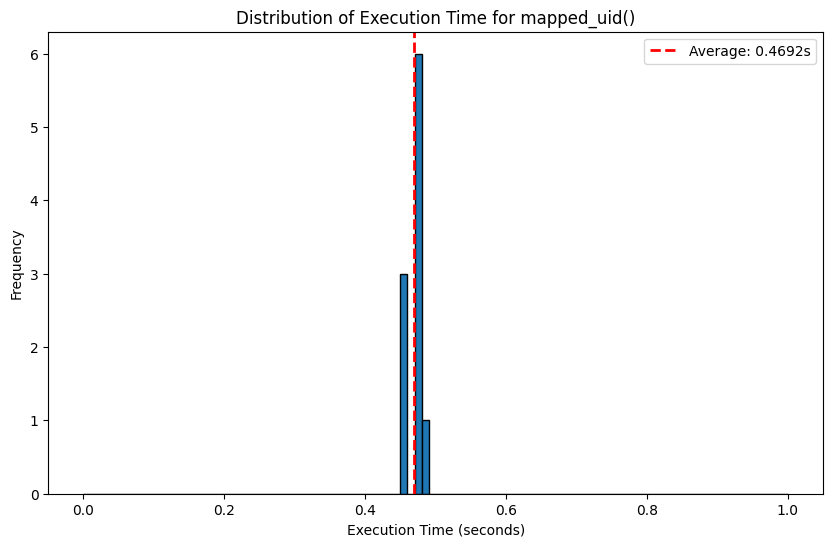

In [66]:
run_func_N_times(mapped_uid, "mapped_uid", N=1000)

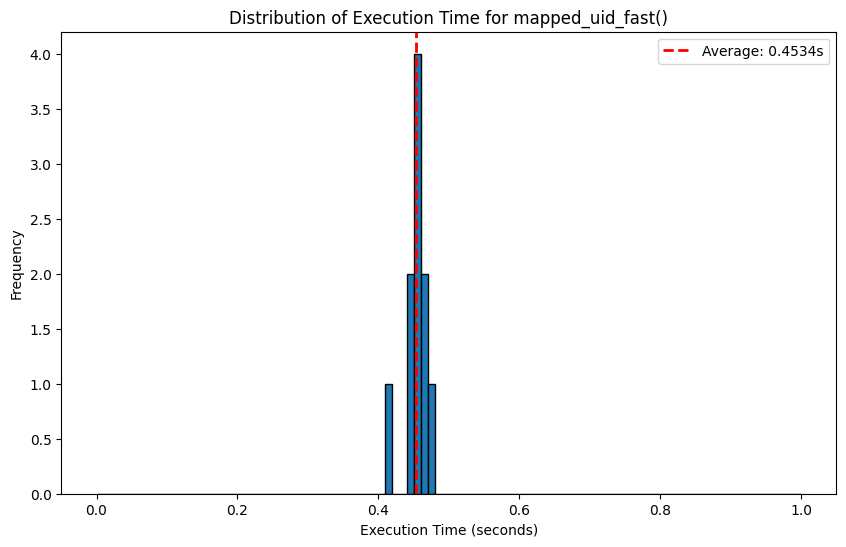

In [67]:
run_func_N_times(mapped_uid_fast, "mapped_uid_fast", N=1000)

# Optimizing `compute_fair` 

In [264]:
%%time
import json
from collections import defaultdict

INPUT_FN = "weibo"
DATE_CUTOFF = "2011-10-28"
TRAIN_CASCADES_SMALL = "data/train_cascades_small.txt"
TRAIN_CASCADES =  "data/train_cascades.txt"
with open("data/attr_users_dict_Full-attempt_2024-03-12.json", "r") as saud_f, open("data/user_attribute_dict_Full-attempt_2024-03-12.json", "r") as suad_f:
#     loaded_attr_users_dict = json.load(saud_f)
#     loaded_user_attribute_dict = json.load(suad_f)
    attr_users_dict = json.load(saud_f)
    user_attribute_dict = json.load(suad_f)
# attr_users_dict = defaultdict(list)
# for key, value in loaded_attr_users_dict.items():
#     attr_users_dict[key] = value

# user_attribute_dict = defaultdict(list)
# for key, value in loaded_user_attribute_dict.items():
#     user_attribute_dict[key] = value
# user_attribute_dict = defaultdict(list)

with open(TRAIN_CASCADES, "r") as f:
    train_cascades_content = f.readlines()

LOG_EVERY = 10000



CPU times: user 668 ms, sys: 184 ms, total: 852 ms
Wall time: 854 ms


## Original implementation from fair_at_scale repo

In [265]:
from collections import defaultdict
import math

def compute_coef(influenced_ratio, log=False):
    """
    Summary: computes fairness for an influenced ratio

    Return: fairness score
    """
    sigma = np.std(influenced_ratio, dtype=np.float64)
    mean = np.mean(influenced_ratio)
    # calculate coefficient of variation of influenced ratio
    coef = sigma/mean
    # scale to 0-1 with sigmoid
    sigmoid = 1 / (1 + math.e ** -coef)
    # return fairness score (this seems to be modified compared to the paper)
    f_score = 2 * (1-sigmoid)
    if log:
        print(f"\tsigma={sigma} ; mean={mean} ; count={len(influenced_ratio)} ; coef={coef} ; sigmoid={sigmoid} ; f_score={f_score}")
    return  f_score


def compute_fair(node_list, user_attribute_dict, attribute_user_agg_dict, attribute='gender', log=False):
    """
    Summary:
    1. Computes influenced ratio
    2. Computes fairness score

    Input:
    1. node_list: list of nodes in the cascade
    2. user_attribute_dict: user to attribute dict (key = uid, val = M/F)
    3. attribute_user_agg_dict: statistics of attribute dict -
        - example: How many males in user_attribute_dict?
        - key = attribute (M/F), val = list of uids
    4. attribute: attribute in consideration, say gender

    Return:
    Fairness score
    """

    # special case: hardcoded values for province feature in weibo
    if attribute == 'province':
        min_f = 0.00537
        # coefficient of scaling get from distribution
        # [0.5,1] a=0.5, b=1, k = (b-a)/(max(score)-min(score))
        k = 0.566
        # 0.5 min scaling border
        score = 0.5 + k * (score-min_f)
        return score

    # intersection of the cascade and the attribute dict
    # example: how many M/F were influenced in the cascade
    # influenced_attribute_dict = {k: user_attribute_dict[k]
    #                              for k in node_list
    #                              if k in user_attribute_dict}
    # influenced statistics
    # Edit from Justin: int(k) is needed bc loading the keys from attributes dict are strings.
    
    influenced_attribute_dict = {k: user_attribute_dict[k] for k in node_list}
    T_grouped = defaultdict(list)
    for k, v in influenced_attribute_dict.items():
        T_grouped[str(v)].append(k)
    ratio = [len(T_grouped[k]) / len(attribute_user_agg_dict[k]) for k in attribute_user_agg_dict.keys()]
    
    if log:
        for k in attribute_user_agg_dict.keys():
            print(f"\tlen(T_grouped[{k}])={len(T_grouped[k])} ; len(attribute_user_agg_dict[{k}])={len(attribute_user_agg_dict[k])}")
        print(f"\t@compute_fair node_list={node_list[:5]}")
#         print(f"\t@compute_fair T_grouped={T_grouped}")

    # influenced_user_agg_dict = defaultdict(list)

    # for k, v in influenced_attribute_dict.items():
    #     influenced_user_agg_dict[v].append(k)

    # influenced ratio for all categories in a dimension
    # this will be a list of ratios for say gender [ratio_m, ratio_f]
    # ratio = np.array([len(influenced_user_agg_dict[k]) /
    #          len(attribute_user_agg_dict[k]) for k in attribute_user_agg_dict.keys()])
    if log:
        print(f"\t@compute_fair ratio={ratio}")

    # compute fairness score
    return compute_coef(ratio, log=log)

### Timing Original

cascade length:  4 1 1500872
0 Skipping cascade bc len=1
cascade length:  15 14 93783
10000 cascade length=14
	len(T_grouped[1])=0 ; len(attribute_user_agg_dict[1])=772630
	len(T_grouped[0])=13 ; len(attribute_user_agg_dict[0])=883048
	@compute_fair node_list=['1581891', '1226523', '741011', '17286', '1607076']
	@compute_fair ratio=[0.0, 1.4721736530743516e-05]
	sigma=7.360868265371758e-06 ; mean=7.360868265371758e-06 ; count=2 ; coef=1.0 ; sigmoid=0.7310585786300049 ; f_score=0.5378828427399902
remove_dup: 0.0001227855682373047s - compute_fair time: 0.00011491775512695312s - f_score: 0.5378828427399902
cascade length:  12 10 86408
20000 cascade length=10
	len(T_grouped[1])=5 ; len(attribute_user_agg_dict[1])=772630
	len(T_grouped[0])=4 ; len(attribute_user_agg_dict[0])=883048
	@compute_fair node_list=['428256', '80768', '301389', '839372', '660371']
	@compute_fair ratio=[6.471402870714313e-06, 4.52976508638262e-06]
	sigma=9.708188921658465e-07 ; mean=5.500583978548466e-06 ; count=2 ;

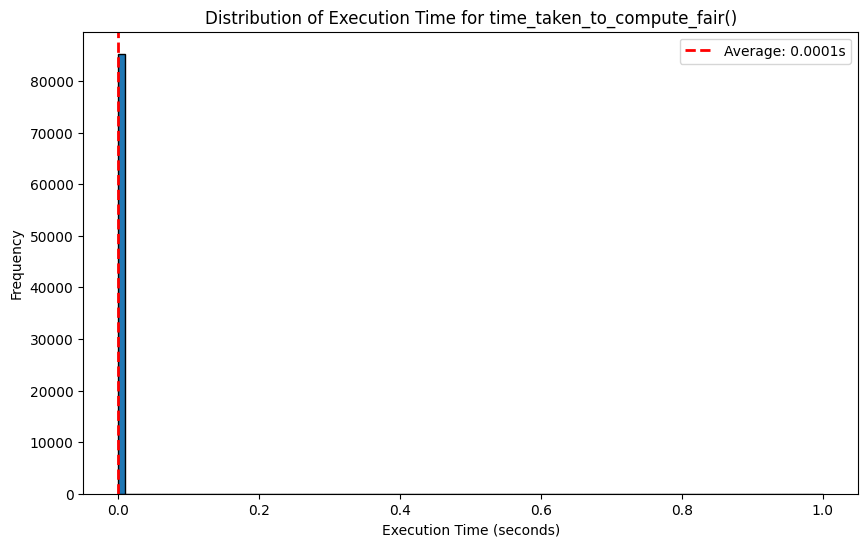

In [266]:
import time
from datetime import datetime

time_taken_to_remove_duplicates = []
time_taken_to_compute_fair = []

for idx, line in enumerate(train_cascades_content):
    log = idx % LOG_EVERY == 0
    cascade = line.replace("\n", "").split(";")
    
    if INPUT_FN == 'weibo':
        # we take cascade[1:] because 0th index is invalid

        # find nodes in a cascade
        cascade_nodes = list(map(lambda x: x.split(" ")[0], cascade[1:]))
        # find seconds elapsed since cutoff time for message to reach the cascade nodes
        cascade_times = list(map(lambda x:
                                int(((datetime.strptime(x.replace("\r", "").split(" ")[1], '%Y-%m-%d-%H:%M:%S') -
                                      datetime.strptime(DATE_CUTOFF, "%Y-%m-%d")).total_seconds())), cascade[1:]))
    else:
        cascade_nodes = list(map(lambda x:  x.split(" ")[0], cascade))
        cascade_times = list(map(lambda x:  int(x.replace("\r", "").split(" ")[1]), cascade))

    # remove duplicates
    start_time = time.time()
    
#     cascade_nodes, cascade_times = remove_duplicates(cascade_nodes, cascade_times)
    cascade_nodes, cascade_times = remove_duplicates_fast(cascade_nodes, cascade_times)
    if log:
        print("cascade length: ", len(cascade), len(cascade_nodes), max(cascade_nodes))
    mid_time = time.time()
    
    if len(cascade_nodes) < 3:
        if log:
            print(f"{idx} Skipping cascade bc len={len(cascade_nodes)}")
        continue
    else:
        if log:
            print(f"{idx} cascade length={len(cascade_nodes)}")

    f_score = compute_fair(cascade_nodes[1:],
                           user_attribute_dict=user_attribute_dict,
                           attribute_user_agg_dict=attr_users_dict,
                           attribute="gender", log=log)
    # old implemntation from fair_at_scale
#     f_score = compute_fair(cascade_nodes,
#                            attribute_dict=user_attribute_dict,
#                            grouped=attribute_grouped,
#                            attribute="gender")
    
    end_time = time.time()
    
    time_taken_to_remove_duplicates.append(mid_time-start_time)
    time_taken_to_compute_fair.append(end_time - mid_time)
    if log:
        print(f"\fremove_dup: {mid_time-start_time}s - compute_fair time: {end_time - mid_time}s - f_score: {f_score}")
    
plot_times(time_taken_to_compute_fair, "time_taken_to_compute_fair")

## Optimized version with vectorizing

TODO: figure out how to load the full `user_attribute_dict` and `attr_users_dict`

In [267]:
import numpy as np
from math import exp


def compute_coef_vec(influenced_ratio, log=False):
    """
    Summary: computes fairness for an influenced ratio

    Return: fairness score
    """
    # Calculate standard deviation and mean efficiently using vectorized operations
    sigma = np.std(influenced_ratio, dtype=np.float64)
    mean = np.mean(influenced_ratio)

    # Avoid division by zero with np.where
    coef = np.where(mean == 0, 0, sigma / mean)

    # Efficient sigmoid calculation with vectorization
    sigmoid = 1 / (1 + math.e ** -coef)
    if log:
        print(f"\tsigma={sigma}, mean={mean}, coef={coef}, sigmoid={sigmoid}")
    # Return fairness score (this seems to be modified compared to the paper)
    return 2 * (1 - sigmoid)


def compute_fair_vec(node_list, user_attribute_dict, attribute_user_agg_dict, attribute='gender', log=False):
    """
    Summary:
    1. Computes influenced ratio
    2. Computes fairness score

    Input:
    1. node_list: list of nodes in the cascade
    2. user_attribute_dict: user to attribute dict (key = uid, val = M/F)
    3. attribute_user_agg_dict: statistics of attribute dict -
        - example: How many males in user_attribute_dict?
        - key = attribute (M/F), val = list of uids
    4. attribute: attribute in consideration, say gender

    Return:
    Fairness score
    """

    # special case: hardcoded values for province feature in weibo
    if attribute == 'province':
        min_f = 0.00537
        # coefficient of scaling get from distribution
        # [0.5,1] a=0.5, b=1, k = (b-a)/(max(score)-min(score))
        k = 0.566
        # 0.5 min scaling border
        score = 0.5 + k * (score-min_f)
        return score

    # intersection of the cascade and the attribute dict
    # example: how many M/F were influenced in the cascade
    influenced_attribute_dict = defaultdict(int)
    for k in node_list:
        influenced_attribute_dict[str(user_attribute_dict[k])] +=1
        
    # influenced ratio for all categories in a dimension
    # this will be a list of ratios for say gender [ratio_m, ratio_f]
    ratio = np.array([influenced_attribute_dict[k] / len(attribute_user_agg_dict.get(k, [])) for k in attribute_user_agg_dict.keys()])

    if log:
        for k in attribute_user_agg_dict.keys():
            print(f"\ttype(k)={type(k)} --> len(influenced_attribute_dict[{k}])={influenced_attribute_dict.get(k)} ; len(attribute_user_agg_dict[{k}])={len(attribute_user_agg_dict.get(k, []))}")
        print(f"\t@compute_fair node_list={node_list[:5]}")
        print(f"\t@compute_fair ratio={ratio}")
        
    return compute_coef_vec(ratio,log=log)


cascade length:  4 1 1500872
0 Skipping cascade bc len=1
cascade length:  15 14 93783
10000 cascade length=14
	type(k)=<class 'str'> --> len(influenced_attribute_dict[1])=0 ; len(attribute_user_agg_dict[1])=772630
	type(k)=<class 'str'> --> len(influenced_attribute_dict[0])=13 ; len(attribute_user_agg_dict[0])=883048
	@compute_fair node_list=['1581891', '1226523', '741011', '17286', '1607076']
	@compute_fair ratio=[0.00000000e+00 1.47217365e-05]
	sigma=7.360868265371758e-06, mean=7.360868265371758e-06, coef=1.0, sigmoid=0.7310585786300049
	remove_dup: 8.606910705566406e-05s - compute_fair time: 0.00015497207641601562s - f_score: 0.5378828427399902
cascade length:  12 10 86408
20000 cascade length=10
	type(k)=<class 'str'> --> len(influenced_attribute_dict[1])=5 ; len(attribute_user_agg_dict[1])=772630
	type(k)=<class 'str'> --> len(influenced_attribute_dict[0])=4 ; len(attribute_user_agg_dict[0])=883048
	@compute_fair node_list=['428256', '80768', '301389', '839372', '660371']
	@comput

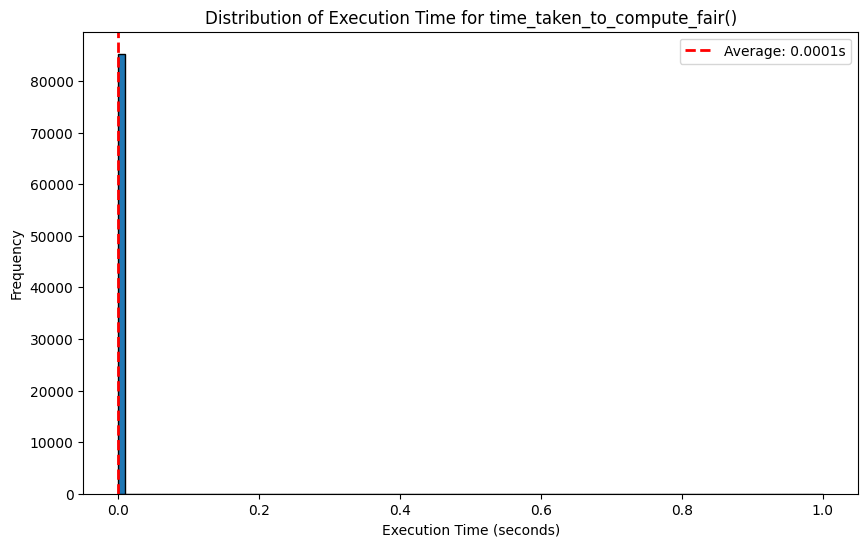

In [268]:
import time
from datetime import datetime

time_taken_to_remove_duplicates = []
time_taken_to_compute_fair = []

for idx, line in enumerate(train_cascades_content):
    log = idx % LOG_EVERY == 0
    cascade = line.replace("\n", "").split(";")
    
    if INPUT_FN == 'weibo':
        # we take cascade[1:] because 0th index is invalid

        # find nodes in a cascade
        cascade_nodes = list(map(lambda x: x.split(" ")[0], cascade[1:]))
        # find seconds elapsed since cutoff time for message to reach the cascade nodes
        cascade_times = list(map(lambda x:
                                int(((datetime.strptime(x.replace("\r", "").split(" ")[1], '%Y-%m-%d-%H:%M:%S') -
                                      datetime.strptime(DATE_CUTOFF, "%Y-%m-%d")).total_seconds())), cascade[1:]))
    else:
        cascade_nodes = list(map(lambda x:  x.split(" ")[0], cascade))
        cascade_times = list(map(lambda x:  int(x.replace("\r", "").split(" ")[1]), cascade))

    # remove duplicates
    start_time = time.time()
    
#     cascade_nodes, cascade_times = remove_duplicates(cascade_nodes, cascade_times)
    cascade_nodes, cascade_times = remove_duplicates_fast(cascade_nodes, cascade_times)
    if log:
        print("cascade length: ", len(cascade), len(cascade_nodes), max(cascade_nodes))
    mid_time = time.time()
    
    if len(cascade_nodes) < 3:
        if log:
            print(f"{idx} Skipping cascade bc len={len(cascade_nodes)}")
        continue
    else:
        if log:
            print(f"{idx} cascade length={len(cascade_nodes)}")

    f_score = compute_fair_vec(cascade_nodes[1:],
                           user_attribute_dict=user_attribute_dict,
                           attribute_user_agg_dict=attr_users_dict,
                           attribute="gender", log=log)
    # old implemntation from fair_at_scale
#     f_score = compute_fair(cascade_nodes,
#                            attribute_dict=user_attribute_dict,
#                            grouped=attribute_grouped,
#                            attribute="gender")
    
    end_time = time.time()
    
    time_taken_to_remove_duplicates.append(mid_time-start_time)
    time_taken_to_compute_fair.append(end_time - mid_time)
    if log:
        print(f"\tremove_dup: {mid_time-start_time}s - compute_fair time: {end_time - mid_time}s - f_score: {f_score}")
    
plot_times(time_taken_to_compute_fair, "time_taken_to_compute_fair")

### Analyzing node_features

In [122]:
import pandas as pd

node_features_small_df = pd.read_csv("data/node_features_small.csv")

In [127]:
node_features_small_df.sort_values("Avg_Cascade_Size", ascending=False)

,Node,Kcores,Participated,Avg_Cascade_Size
944,1004172,533,0,33044.0
39,80510,533,0,31009.0
26,27326,533,0,30430.0
73692,464593,462,0,27172.0
165,828102,533,0,25467.0
...,...,...,...,...
1170683,1787054,72,0,NaN
1170684,1787176,21,0,NaN
1170685,1787295,40,0,NaN
1170686,1787334,45,0,NaN


In [147]:
def remove_duplicates(cascade_nodes, cascade_times):
    """
    Some tweets have more then one retweets from the same person
    Keep only the first retweet of that person
    """
    duplicates = set([x for x in cascade_nodes if cascade_nodes.count(x) > 1])
    for d in duplicates:
        to_remove = [v for v, b in enumerate(cascade_nodes) if b == d][1:]
        print(to_remove)
        cascade_nodes = [b for v, b in enumerate(cascade_nodes) if v not in to_remove]
        cascade_times = [b for v, b in enumerate(cascade_times) if v not in to_remove]
        
    return cascade_nodes, cascade_times

In [148]:
remove_duplicates([1,2,3,1], ["a"]*4)

{1}
[3]


([1, 2, 3], ['a', 'a', 'a'])